In [46]:
#Cargamos las librerías necesarias 
import pandas as pd
import pymongo 
import holidays
from prophet import Prophet
import matplotlib.pyplot as plt

In [47]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client['Covid_19_Caro_Gutierrez'] 

collection = db['Mobility']
# Consulta MongoDB y carga los documentos en un cursor
data = collection.find()
df_mob = pd.DataFrame(list(data))
df_mob.drop('_id', axis=1, inplace=True)
df_mob.drop('place_id', axis=1, inplace=True)

In [48]:
df_mob['iso_3166_2_code'].unique()

array([nan, 'DE-BW', 'DE-BY', 'DE-BE', 'DE-BB', 'DE-HB', 'DE-HH', 'DE-HE',
       'DE-NI', 'DE-MV', 'DE-NW', 'DE-RP', 'DE-SL', 'DE-SN', 'DE-ST',
       'DE-SH', 'DE-TH', 'FR-ARA', 'FR-01', 'FR-03', 'FR-07', 'FR-15',
       'FR-26', 'FR-43', 'FR-74', 'FR-38', 'FR-42', 'FR-63', 'FR-69',
       'FR-73', 'FR-BFC', 'FR-21', 'FR-25', 'FR-70', 'FR-39', 'FR-58',
       'FR-71', 'FR-90', 'FR-89', 'FR-BRE', 'FR-22', 'FR-29', 'FR-35',
       'FR-56', 'FR-CVL', 'FR-18', 'FR-28', 'FR-36', 'FR-37', 'FR-41',
       'FR-45', 'FR-COR', 'FR-2A', 'FR-2B', 'FR-GES', 'FR-08', 'FR-10',
       'FR-67', 'FR-68', 'FR-52', 'FR-51', 'FR-54', 'FR-55', 'FR-57',
       'FR-88', 'FR-HDF', 'FR-02', 'FR-59', 'FR-60', 'FR-62', 'FR-80',
       'FR-IDF', 'FR-91', 'FR-92', 'FR-75', 'FR-77', 'FR-93', 'FR-95',
       'FR-94', 'FR-78', 'FR-NOR', 'FR-14', 'FR-27', 'FR-50', 'FR-61',
       'FR-76', 'FR-NAQ', 'FR-16', 'FR-17', 'FR-19', 'FR-23', 'FR-79',
       'FR-24', 'FR-33', 'FR-87', 'FR-40', 'FR-47', 'FR-64', 'FR-86',
     

In [49]:
df_mob = df_mob.dropna(subset=["iso_3166_2_code"])

In [50]:
df_mob = df_mob.rename(columns={ 'country_region': 'country'})

In [51]:
def get_prediction(df):
    prediction = {}
    codes = df.iso_3166_2_code.unique()
    df.rename(columns={'date': 'ds', 'workplaces_percent_change_from_baseline': 'y'}, inplace=True)

    for code in codes:
        municipio_df = df.loc[df['iso_3166_2_code'] == code]
        my_model = Prophet(changepoint_prior_scale=0.5)
        # Configura las vacaciones para el país correspondiente
        if municipio_df['country'].iloc[0] == 'Spain':
            my_model.add_country_holidays(country_name='ES')
        elif municipio_df['country'].iloc[0] == 'Sweden':
            my_model.add_country_holidays(country_name='SE')
        elif municipio_df['country'].iloc[0] == 'Germany':
            my_model.add_country_holidays(country_name='DE')
        elif municipio_df['country'].iloc[0] == 'France':
            my_model.add_country_holidays(country_name='FR')
        elif municipio_df['country'].iloc[0] == 'Italy':
            my_model.add_country_holidays(country_name='IT')

        my_model = my_model.fit(municipio_df)
        future_dates = my_model.make_future_dataframe(periods=1, freq='D')
        forecast = my_model.predict(future_dates)
        prediction[code] = forecast
    return prediction


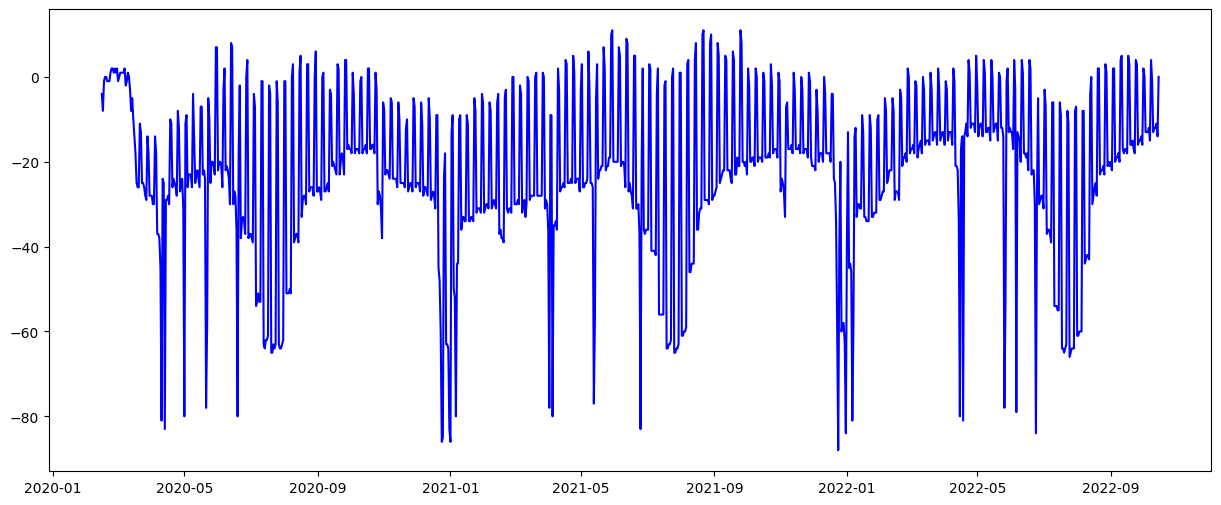

In [52]:
zaragoza_data = df_mob[df_mob['iso_3166_2_code'] == 'SE-O']

# Configura el tamaño del gráfico
plt.figure(figsize=(15, 6))

# Grafica la serie temporal 'workplaces_percent_change_from_baseline' para Zaragoza
plt.plot(zaragoza_data['date'], zaragoza_data['workplaces_percent_change_from_baseline'], label='Valores reales', color='blue')

In [53]:
prediction = get_prediction(df_mob)

17:00:09 - cmdstanpy - INFO - Chain [1] start processing
17:00:10 - cmdstanpy - INFO - Chain [1] done processing
17:00:10 - cmdstanpy - INFO - Chain [1] start processing
17:00:10 - cmdstanpy - INFO - Chain [1] done processing
17:00:11 - cmdstanpy - INFO - Chain [1] start processing
17:00:11 - cmdstanpy - INFO - Chain [1] done processing
17:00:11 - cmdstanpy - INFO - Chain [1] start processing
17:00:12 - cmdstanpy - INFO - Chain [1] done processing
17:00:12 - cmdstanpy - INFO - Chain [1] start processing
17:00:12 - cmdstanpy - INFO - Chain [1] done processing
17:00:13 - cmdstanpy - INFO - Chain [1] start processing
17:00:13 - cmdstanpy - INFO - Chain [1] done processing
17:00:13 - cmdstanpy - INFO - Chain [1] start processing
17:00:14 - cmdstanpy - INFO - Chain [1] done processing
17:00:14 - cmdstanpy - INFO - Chain [1] start processing
17:00:14 - cmdstanpy - INFO - Chain [1] done processing
17:00:15 - cmdstanpy - INFO - Chain [1] start processing
17:00:15 - cmdstanpy - INFO - Chain [1]

In [54]:
df = pd.DataFrame(columns=['ds', 'trend', 'iso_3166_2_code'])

# Iterar a través del diccionario y agregar los datos al DataFrame
for code, data in prediction.items():
    temp_df = pd.DataFrame(data)
    temp_df['iso_3166_2_code'] = code
    df = pd.concat([df, temp_df], ignore_index=True)

# Asegúrate de convertir la columna 'ds' a tipo datetime si aún no lo está
df['date'] = pd.to_datetime(df['ds'])

C:\Users\34645\AppData\Local\Temp\ipykernel_16368\1918796315.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df], ignore_index=True)


In [55]:
dataset = pd.merge(df_mob, df, left_on=['ds', 'iso_3166_2_code'], right_on=['ds', 'iso_3166_2_code'], how='inner')


In [56]:
dataset['workplaces'] = dataset['trend'] + dataset['yearly'] 

In [57]:
dataset

,country_region_code,country,ds,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,y,residential_percent_change_from_baseline,sub_region_1,...,New Year's Eve_lower,New Year's Eve_upper,Sunday,Sunday_lower,Sunday_upper,Whit Sunday,Whit Sunday_lower,Whit Sunday_upper,date,workplaces
0,DE,Germany,2020-02-15,6.0,1.0,52.0,10.0,3.0,-1.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-15,-6.951264
1,DE,Germany,2020-02-16,23.0,43.0,64.0,20.0,1.0,-2.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-16,-7.310751
2,DE,Germany,2020-02-17,0.0,-1.0,-11.0,0.0,-1.0,1.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-17,-7.566160
3,DE,Germany,2020-02-18,4.0,3.0,16.0,1.0,0.0,1.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-18,-7.729673
4,DE,Germany,2020-02-19,2.0,0.0,3.0,-2.0,-1.0,0.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-19,-7.815536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370555,SE,Sweden,2022-10-11,-5.0,7.0,92.0,-16.0,-12.0,2.0,Västra Götaland County,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-10-11,-12.062356
370556,SE,Sweden,2022-10-12,-7.0,4.0,59.0,-22.0,-12.0,3.0,Västra Götaland County,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-10-12,-12.272986
370557,SE,Sweden,2022-10-13,-6.0,7.0,55.0,-19.0,-11.0,3.0,Västra Götaland County,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-10-13,-12.466228
370558,SE,Sweden,2022-10-14,-4.0,6.0,69.0,-18.0,-14.0,3.0,Västra Götaland County,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-10-14,-12.639521


In [58]:
ruta_del_archivo = r"C:\Users\34645\Downloads\c2m_workplace_closing.csv"

# Carga el archivo CSV en un DataFrame
c2m = pd.read_csv(ruta_del_archivo)

In [59]:
c2m

,Unnamed: 0,country_code,country_name,region_code,region_name,jurisdiction,01Jan2020,02Jan2020,03Jan2020,04Jan2020,...,11Feb2023,12Feb2023,13Feb2023,14Feb2023,15Feb2023,16Feb2023,17Feb2023,18Feb2023,19Feb2023,20Feb2023
0,1,ABW,Aruba,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,AFG,Afghanistan,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,AGO,Angola,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,ALB,Albania,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,AND,Andorra,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,259,VUT,Vanuatu,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,260,YEM,Yemen,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,261,ZAF,South Africa,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,262,ZMB,Zambia,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
c2m.drop('Unnamed: 0', axis=1, inplace=True)
c2m.drop('jurisdiction', axis=1, inplace=True)

# Derretir el DataFrame
c2m = c2m.melt(id_vars=['country_code','country_name', 'region_code',	'region_name'], var_name='date', value_name=f'workplace_closing')    

In [61]:
c2m['date'] = pd.to_datetime(c2m['date'], format='%d%b%Y').dt.strftime('%Y-%m-%d')
c2m['date'] = c2m['date'].astype('datetime64[ns]')
c2m['year'] = c2m['date'].dt.strftime('%Y')

In [62]:
c2m

,country_code,country_name,region_code,region_name,date,workplace_closing,year
0,ABW,Aruba,NaN,NaN,2020-01-01,0.0,2020
1,AFG,Afghanistan,NaN,NaN,2020-01-01,0.0,2020
2,AGO,Angola,NaN,NaN,2020-01-01,0.0,2020
3,ALB,Albania,NaN,NaN,2020-01-01,0.0,2020
4,AND,Andorra,NaN,NaN,2020-01-01,0.0,2020
...,...,...,...,...,...,...,...
301656,VUT,Vanuatu,NaN,NaN,2023-02-20,NaN,2023
301657,YEM,Yemen,NaN,NaN,2023-02-20,NaN,2023
301658,ZAF,South Africa,NaN,NaN,2023-02-20,NaN,2023
301659,ZMB,Zambia,NaN,NaN,2023-02-20,NaN,2023


In [63]:
#Oxford CGRT data
db = client['MobilityReports'] 
Stringency_Index = db['Stringency_Index']
GovernmentResponseIndex = db['GovernmentResponseIndex']
EconomicSupportIndex = db['EconomicSupportIndex']
Containment_Health_index = db['Containment_Health_index']

countries = ['Sweden', 'Spain', 'Italy', 'France']
data_frames = []

# Define una función para aplicar las modificaciones y renombrar la columna "Valor"
def aplicar_modificaciones(df, nombre):
    # Elimina las columnas innecesarias
    df.drop('_id', axis=1, inplace=True)
    df.drop('CountryCode', axis=1, inplace=True)
    df.drop('Jurisdiction', axis=1, inplace=True)
    
    # Renombra la columna "Valor"
    df.rename(columns={'Valor': f'Valor_{nombre}'}, inplace=True)
    
    # Derretir el DataFrame
    df_melted = df.melt(id_vars=['CountryName'], var_name='date', value_name=f'Valor_{nombre}')
    
    return df_melted

for country in countries:
    # Realiza la consulta para obtener los datos del país
    query = {'CountryName': country}

    # Carga los DataFrames desde MongoDB
    df_stringency = pd.DataFrame(list(Stringency_Index.find(query)))
    df_government = pd.DataFrame(list(GovernmentResponseIndex.find(query)))
    df_economic = pd.DataFrame(list(EconomicSupportIndex.find(query)))
    df_containment_health = pd.DataFrame(list(Containment_Health_index.find(query)))

    # Aplica las modificaciones a cada DataFrame y renombra la columna "Valor"
    df_stringency = aplicar_modificaciones(df_stringency, 'Stringency_Index')
    df_government = aplicar_modificaciones(df_government, 'GovernmentResponseIndex')
    df_economic = aplicar_modificaciones(df_economic, 'EconomicSupportIndex')
    df_containment_health = aplicar_modificaciones(df_containment_health, 'Containment_Health_index')

    # Combina todos los DataFrames en uno solo basado en la columna "date"
    df_final = df_stringency.merge(df_government, on='date', how='inner', suffixes=('_stringency', '_government')) \
                        .merge(df_economic, on='date', how='inner', suffixes=('_government', '_economic')) \
                        .merge(df_containment_health, on='date', how='inner', suffixes=('_economic', '_containment_health'))
    
    # Elimina las columnas de nombres de países redundantes
    df_final.drop(['CountryName_government', 'CountryName_economic', 'CountryName_containment_health'], axis=1, inplace=True)
    
    # Agrega el DataFrame final a la lista de DataFrames
    data_frames.append(df_final)

# Concatena todos los DataFrames en uno solo
df_final = pd.concat(data_frames, axis=0, ignore_index=True)

# Imprime el DataFrame final


df_final['date'] = pd.to_datetime(df_final['date'], format='%d%b%Y').dt.strftime('%Y-%m-%d')
df_final['date'] = df_final['date'].astype('datetime64[ns]')
df_final['year'] = df_final['date'].dt.strftime('%Y')

In [64]:
df_final = df_final.rename(columns={ 'CountryName_stringency': 'country'})


In [65]:
c2m = c2m.rename(columns={ 'country_name': 'country'})

In [66]:
ox_data = df_final.merge(c2m, on=['date', 'country'], how='left')

In [67]:
ox_data

,country,date,Valor_Stringency_Index,Valor_GovernmentResponseIndex,Valor_EconomicSupportIndex,Valor_Containment_Health_index,year_x,country_code,region_code,region_name,workplace_closing,year_y
0,Sweden,2020-01-01,0,0,0,0,2020,SWE,NaN,NaN,0.0,2020
1,Sweden,2020-01-02,0,0,0,0,2020,SWE,NaN,NaN,0.0,2020
2,Sweden,2020-01-03,0,0,0,0,2020,SWE,NaN,NaN,0.0,2020
3,Sweden,2020-01-04,0,0,0,0,2020,SWE,NaN,NaN,0.0,2020
4,Sweden,2020-01-05,0,0,0,0,2020,SWE,NaN,NaN,0.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
4379,France,2022-12-27,"11,11","22,4",0,"25,6",2022,FRA,NaN,NaN,0.0,2022
4380,France,2022-12-28,"11,11","22,4",0,"25,6",2022,FRA,NaN,NaN,0.0,2022
4381,France,2022-12-29,"11,11","22,4",0,"25,6",2022,FRA,NaN,NaN,0.0,2022
4382,France,2022-12-30,"11,11","22,4",0,"25,6",2022,FRA,NaN,NaN,0.0,2022


In [68]:
data = dataset.merge(ox_data, on=['date', 'country'], how='left')

In [69]:
data

,country_region_code,country,ds,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,y,residential_percent_change_from_baseline,sub_region_1,...,Valor_Stringency_Index,Valor_GovernmentResponseIndex,Valor_EconomicSupportIndex,Valor_Containment_Health_index,year_x,country_code,region_code,region_name,workplace_closing,year_y
0,DE,Germany,2020-02-15,6.0,1.0,52.0,10.0,3.0,-1.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DE,Germany,2020-02-16,23.0,43.0,64.0,20.0,1.0,-2.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DE,Germany,2020-02-17,0.0,-1.0,-11.0,0.0,-1.0,1.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DE,Germany,2020-02-18,4.0,3.0,16.0,1.0,0.0,1.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DE,Germany,2020-02-19,2.0,0.0,3.0,-2.0,-1.0,0.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370555,SE,Sweden,2022-10-11,-5.0,7.0,92.0,-16.0,-12.0,2.0,Västra Götaland County,...,"11,11","14,58",0,"16,67",2022,SWE,NaN,NaN,0.0,2022
370556,SE,Sweden,2022-10-12,-7.0,4.0,59.0,-22.0,-12.0,3.0,Västra Götaland County,...,"11,11","14,58",0,"16,67",2022,SWE,NaN,NaN,0.0,2022
370557,SE,Sweden,2022-10-13,-6.0,7.0,55.0,-19.0,-11.0,3.0,Västra Götaland County,...,"11,11","14,58",0,"16,67",2022,SWE,NaN,NaN,0.0,2022
370558,SE,Sweden,2022-10-14,-4.0,6.0,69.0,-18.0,-14.0,3.0,Västra Götaland County,...,"11,11","14,58",0,"16,67",2022,SWE,NaN,NaN,0.0,2022


In [70]:
# Ruta al archivo CSV
ruta_del_archivo = r"C:\Users\34645\Downloads\Global_summary_covid19_confirmed.csv"

# Carga el archivo CSV en un DataFrame
cases = pd.read_csv(ruta_del_archivo)

In [71]:
cases

,id,iso3,admin0_name,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,...,2022-02-18,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24,2022-02-25,2022-02-26,2022-02-27
0,3567,AFG,Afghanistan,0,0,0,0,0,0,0,...,171857,171931,172205,172441,172716,172901,173047,173084,173146,173395
1,112919,ALB,Albania,0,0,0,0,0,0,0,...,269601,269904,270164,270370,270455,270734,270947,271141,271141,271527
2,137103,DZA,Algeria,0,0,0,0,0,0,0,...,263685,263936,264054,264201,264365,264488,264603,264706,264778,264855
3,32438,AND,Andorra,0,0,0,0,0,0,0,...,37589,37589,37589,37589,37820,37901,37958,37999,37999,37999
4,94127,AGO,Angola,0,0,0,0,0,0,0,...,98605,98617,98638,98658,98671,98698,98701,98701,98701,98701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,38039,VEN,Venezuela,0,0,0,0,0,0,0,...,509947,510553,510553,511073,511772,512560,512947,513427,514315,514315
199,132075,VNM,Vietnam,0,2,2,2,2,2,2,...,2685463,2740293,2787493,2834373,2890522,2972378,3041506,3120301,3219177,3321005
200,44964,ESH,Western Sahara,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
201,19716,ZMB,Zambia,0,0,0,0,0,0,0,...,310764,311016,311194,311264,311592,311888,312118,312374,312611,312707


In [72]:
# Derretir el DataFrame
cases = cases.melt(id_vars=['admin0_name','iso3', 'id'], var_name='date', value_name=f'daily_cases')
cases = cases.rename(columns={ 'admin0_name': 'country'})

In [73]:
cases['date'] = cases['date'].astype('datetime64[ns]')

In [74]:
data = data.merge(cases, on=['date', 'country'], how='left')

In [75]:
data

,country_region_code,country,ds,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,y,residential_percent_change_from_baseline,sub_region_1,...,Valor_Containment_Health_index,year_x,country_code,region_code,region_name,workplace_closing,year_y,iso3,id,daily_cases
0,DE,Germany,2020-02-15,6.0,1.0,52.0,10.0,3.0,-1.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEU,104048.0,16.0
1,DE,Germany,2020-02-16,23.0,43.0,64.0,20.0,1.0,-2.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEU,104048.0,16.0
2,DE,Germany,2020-02-17,0.0,-1.0,-11.0,0.0,-1.0,1.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEU,104048.0,16.0
3,DE,Germany,2020-02-18,4.0,3.0,16.0,1.0,0.0,1.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEU,104048.0,16.0
4,DE,Germany,2020-02-19,2.0,0.0,3.0,-2.0,-1.0,0.0,Baden-Württemberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEU,104048.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370555,SE,Sweden,2022-10-11,-5.0,7.0,92.0,-16.0,-12.0,2.0,Västra Götaland County,...,"16,67",2022,SWE,NaN,NaN,0.0,2022,NaN,NaN,NaN
370556,SE,Sweden,2022-10-12,-7.0,4.0,59.0,-22.0,-12.0,3.0,Västra Götaland County,...,"16,67",2022,SWE,NaN,NaN,0.0,2022,NaN,NaN,NaN
370557,SE,Sweden,2022-10-13,-6.0,7.0,55.0,-19.0,-11.0,3.0,Västra Götaland County,...,"16,67",2022,SWE,NaN,NaN,0.0,2022,NaN,NaN,NaN
370558,SE,Sweden,2022-10-14,-4.0,6.0,69.0,-18.0,-14.0,3.0,Västra Götaland County,...,"16,67",2022,SWE,NaN,NaN,0.0,2022,NaN,NaN,NaN


In [76]:
# Lista de nombres de columnas que deseas eliminar

columnas_a_eliminar= [
    "year_x", 'year_y', "country_code", "region_code", "region_name", 'id',
    'country_region_code',
 'yhat_lower',
 'yhat_upper',
 'trend_lower',
 'trend_upper',
 'Ascension Day',
 'Ascension Day_lower',
 'Ascension Day_upper',
 'Christmas Day',
 'Christmas Day_lower',
 'Christmas Day_upper',
 'Easter Monday',
 'Easter Monday_lower',
 'Easter Monday_upper',
 'German Unity Day',
 'German Unity Day_lower',
 'German Unity Day_upper',
 'Good Friday',
 'Good Friday_lower',
 'Good Friday_upper',
 'Labor Day',
 'Labor Day_lower',
 'Labor Day_upper',
 "New Year's Day",
 "New Year's Day_lower",
 "New Year's Day_upper",
 'Second Day of Christmas',
 'Second Day of Christmas_lower',
 'Second Day of Christmas_upper',
 'Whit Monday',
 'Whit Monday_lower',
 'Whit Monday_upper',
 'additive_terms',
 'additive_terms_lower',
 'additive_terms_upper',
 'holidays',
 'holidays_lower',
 'holidays_upper',
 'weekly',
 'weekly_lower',
 'weekly_upper',
 'yearly',
 'yearly_lower',
 'yearly_upper',
 'multiplicative_terms',
 'multiplicative_terms_lower',
 'multiplicative_terms_upper',
 'yhat',
 "All Saints' Day",
 "All Saints' Day_lower",
 "All Saints' Day_upper",
 'Armistice Day',
 'Armistice Day_lower',
 'Armistice Day_upper',
 'Assumption Day',
 'Assumption Day_lower',
 'Assumption Day_upper',
 'National Day',
 'National Day_lower',
 'National Day_upper',
 'Victory Day',
 'Victory Day_lower',
 'Victory Day_upper',
 'Assunzione della Vergine',
 'Assunzione della Vergine_lower',
 'Assunzione della Vergine_upper',
 'Capodanno',
 'Capodanno_lower',
 'Capodanno_upper',
 'Epifania del Signore',
 'Epifania del Signore_lower',
 'Epifania del Signore_upper',
 'Festa dei Lavoratori',
 'Festa dei Lavoratori_lower',
 'Festa dei Lavoratori_upper',
 'Festa della Liberazione',
 'Festa della Liberazione_lower',
 'Festa della Liberazione_upper',
 'Festa della Repubblica',
 'Festa della Repubblica_lower',
 'Festa della Repubblica_upper',
 'Immacolata Concezione',
 'Immacolata Concezione_lower',
 'Immacolata Concezione_upper',
 "Lunedì dell'Angelo",
 "Lunedì dell'Angelo_lower",
 "Lunedì dell'Angelo_upper",
 'Natale',
 'Natale_lower',
 'Natale_upper',
 'Pasqua di Resurrezione',
 'Pasqua di Resurrezione_lower',
 'Pasqua di Resurrezione_upper',
 'Santo Stefano',
 'Santo Stefano_lower',
 'Santo Stefano_upper',
 'Tutti i Santi',
 'Tutti i Santi_lower',
 'Tutti i Santi_upper',
 'Asunción de la Virgen',
 'Asunción de la Virgen_lower',
 'Asunción de la Virgen_upper',
 'Año nuevo',
 'Año nuevo_lower',
 'Año nuevo_upper',
 'Día de la Constitución Española',
 'Día de la Constitución Española_lower',
 'Día de la Constitución Española_upper',
 'Epifanía del Señor',
 'Epifanía del Señor_lower',
 'Epifanía del Señor_upper',
 'Fiesta Nacional de España',
 'Fiesta Nacional de España_lower',
 'Fiesta Nacional de España_upper',
 'Fiesta del Trabajo',
 'Fiesta del Trabajo_lower',
 'Fiesta del Trabajo_upper',
 'Inmaculada Concepción',
 'Inmaculada Concepción_lower',
 'Inmaculada Concepción_upper',
 'Natividad del Señor',
 'Natividad del Señor_lower',
 'Natividad del Señor_upper',
 'Todos los Santos',
 'Todos los Santos_lower',
 'Todos los Santos_upper',
 'Viernes Santo',
 'Viernes Santo_lower',
 'Viernes Santo_upper',
 'Christmas Eve',
 'Christmas Eve_lower',
 'Christmas Eve_upper',
 'Easter Sunday',
 'Easter Sunday_lower',
 'Easter Sunday_upper',
 'Epiphany',
 'Epiphany_lower',
 'Epiphany_upper',
 'May Day',
 'May Day_lower',
 'May Day_upper',
 'Midsummer Day',
 'Midsummer Day_lower',
 'Midsummer Day_upper',
 'Midsummer Eve',
 'Midsummer Eve_lower',
 'Midsummer Eve_upper',
 'National Day of Sweden',
 'National Day of Sweden_lower',
 'National Day of Sweden_upper',
 "New Year's Eve",
 "New Year's Eve_lower",
 "New Year's Eve_upper",
 'Sunday',
 'Sunday_lower',
 'Sunday_upper',
 'Whit Sunday',
 'Whit Sunday_lower',
 'Whit Sunday_upper',
 'iso3',
 'sub_region_2',]

# Utiliza el método drop para eliminar las columnas
data = data.drop(columnas_a_eliminar, axis=1)

In [77]:
data.columns.tolist()

['country',
 'ds',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'y',
 'residential_percent_change_from_baseline',
 'sub_region_1',
 'iso_3166_2_code',
 'trend',
 'date',
 'workplaces',
 'Valor_Stringency_Index',
 'Valor_GovernmentResponseIndex',
 'Valor_EconomicSupportIndex',
 'Valor_Containment_Health_index',
 'workplace_closing',
 'daily_cases']

In [78]:
columnas_porcentajes = [ 
    'Valor_Stringency_Index', 'Valor_GovernmentResponseIndex', 'Valor_EconomicSupportIndex', 'Valor_Containment_Health_index',  
]

# Función para convertir la notación española a float
def convertir_porcentaje(texto):
    # Verificar si es una cadena antes de realizar la conversión
    if isinstance(texto, str):
        # Reemplazar comas por puntos y luego convertir a float
        return float(texto.replace(',', '.'))
    return texto

# Aplicar la función de conversión a las columnas de porcentajes
data[columnas_porcentajes] = data[columnas_porcentajes].applymap(convertir_porcentaje)

C:\Users\34645\AppData\Local\Temp\ipykernel_16368\3581785137.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[columnas_porcentajes] = data[columnas_porcentajes].applymap(convertir_porcentaje)


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370560 entries, 0 to 370559
Data columns (total 19 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   country                                             370560 non-null  object        
 1   ds                                                  370560 non-null  datetime64[ns]
 2   retail_and_recreation_percent_change_from_baseline  369380 non-null  float64       
 3   grocery_and_pharmacy_percent_change_from_baseline   367683 non-null  float64       
 4   parks_percent_change_from_baseline                  353911 non-null  float64       
 5   transit_stations_percent_change_from_baseline       361556 non-null  float64       
 6   y                                                   370560 non-null  float64       
 7   residential_percent_change_from_baseline            369137 non-null  float64       

In [80]:
data = data.rename(columns={ 'y': 'workplaces_raw'})

In [81]:
#Crear dummy
data['d2'] = 0  # Inicialmente, establece todos los valores en 0

# Condición 1: País es Sweden y fecha mayor o igual a '2021-07-15'
condicion_1 = (data['country'] == 'Sweden') & (data['date'] >= '2021-07-15') 

# Condición 2: País es España y fecha igual a '2021-08-23'
condicion_2 = (data['country'] == 'Spain') & (data['date'] >= '2021-08-23') 
data
# Asigna 1 a la columna "dummy" si alguna de las condiciones se cumple
data.loc[condicion_1 | condicion_2, 'd2'] = 1

In [82]:
data['d1'] = 0  # Inicialmente, establece todos los valores en 0

# Condición 1: País es Sweden y fecha mayor o igual a '2021-07-15'
condicion_1 = (data['country'] == 'Sweden') & (data['date'] >= '2021-06-01') 
# Condición 2: País es España y fecha igual a '2021-08-23'
condicion_2 = (data['country'] == 'Spain') & (data['date'] >= '2021-06-21') 

data
# Asigna 1 a la columna "dummy" si alguna de las condiciones se cumple
data.loc[condicion_1 | condicion_2, 'd1'] = 1

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370560 entries, 0 to 370559
Data columns (total 21 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   country                                             370560 non-null  object        
 1   ds                                                  370560 non-null  datetime64[ns]
 2   retail_and_recreation_percent_change_from_baseline  369380 non-null  float64       
 3   grocery_and_pharmacy_percent_change_from_baseline   367683 non-null  float64       
 4   parks_percent_change_from_baseline                  353911 non-null  float64       
 5   transit_stations_percent_change_from_baseline       361556 non-null  float64       
 6   workplaces_raw                                      370560 non-null  float64       
 7   residential_percent_change_from_baseline            369137 non-null  float64       

In [84]:
# Supongamos que tienes un DataFrame llamado dataset con una columna 'date' que contiene las fechas
# Asegúrate de que la columna 'date' esté en formato de fecha (datetime)
#data['date'] = pd.date(data['date'])

# Define la fecha de inicio y la fecha de fin del intervalo
fecha_inicio = pd.to_datetime('2020-02-15')
fecha_fin = pd.to_datetime('2022-10-15')

# Calcula el número de período para cada fecha
data['Periodo'] = (data['date'] - fecha_inicio).dt.days + 1

# Muestra el DataFrame resultante


In [85]:
# Reemplazar NaN por 0 en todas las columnas
data.fillna(0, inplace=True)

In [86]:
data

,country,ds,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_raw,residential_percent_change_from_baseline,sub_region_1,iso_3166_2_code,...,workplaces,Valor_Stringency_Index,Valor_GovernmentResponseIndex,Valor_EconomicSupportIndex,Valor_Containment_Health_index,workplace_closing,daily_cases,d2,d1,Periodo
0,Germany,2020-02-15,6.0,1.0,52.0,10.0,3.0,-1.0,Baden-Württemberg,DE-BW,...,-6.951264,0.00,0.00,0.0,0.00,0.0,16.0,0,0,1
1,Germany,2020-02-16,23.0,43.0,64.0,20.0,1.0,-2.0,Baden-Württemberg,DE-BW,...,-7.310751,0.00,0.00,0.0,0.00,0.0,16.0,0,0,2
2,Germany,2020-02-17,0.0,-1.0,-11.0,0.0,-1.0,1.0,Baden-Württemberg,DE-BW,...,-7.566160,0.00,0.00,0.0,0.00,0.0,16.0,0,0,3
3,Germany,2020-02-18,4.0,3.0,16.0,1.0,0.0,1.0,Baden-Württemberg,DE-BW,...,-7.729673,0.00,0.00,0.0,0.00,0.0,16.0,0,0,4
4,Germany,2020-02-19,2.0,0.0,3.0,-2.0,-1.0,0.0,Baden-Württemberg,DE-BW,...,-7.815536,0.00,0.00,0.0,0.00,0.0,16.0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370555,Sweden,2022-10-11,-5.0,7.0,92.0,-16.0,-12.0,2.0,Västra Götaland County,SE-O,...,-12.062356,11.11,14.58,0.0,16.67,0.0,0.0,1,1,970
370556,Sweden,2022-10-12,-7.0,4.0,59.0,-22.0,-12.0,3.0,Västra Götaland County,SE-O,...,-12.272986,11.11,14.58,0.0,16.67,0.0,0.0,1,1,971
370557,Sweden,2022-10-13,-6.0,7.0,55.0,-19.0,-11.0,3.0,Västra Götaland County,SE-O,...,-12.466228,11.11,14.58,0.0,16.67,0.0,0.0,1,1,972
370558,Sweden,2022-10-14,-4.0,6.0,69.0,-18.0,-14.0,3.0,Västra Götaland County,SE-O,...,-12.639521,11.11,14.58,0.0,16.67,0.0,0.0,1,1,973


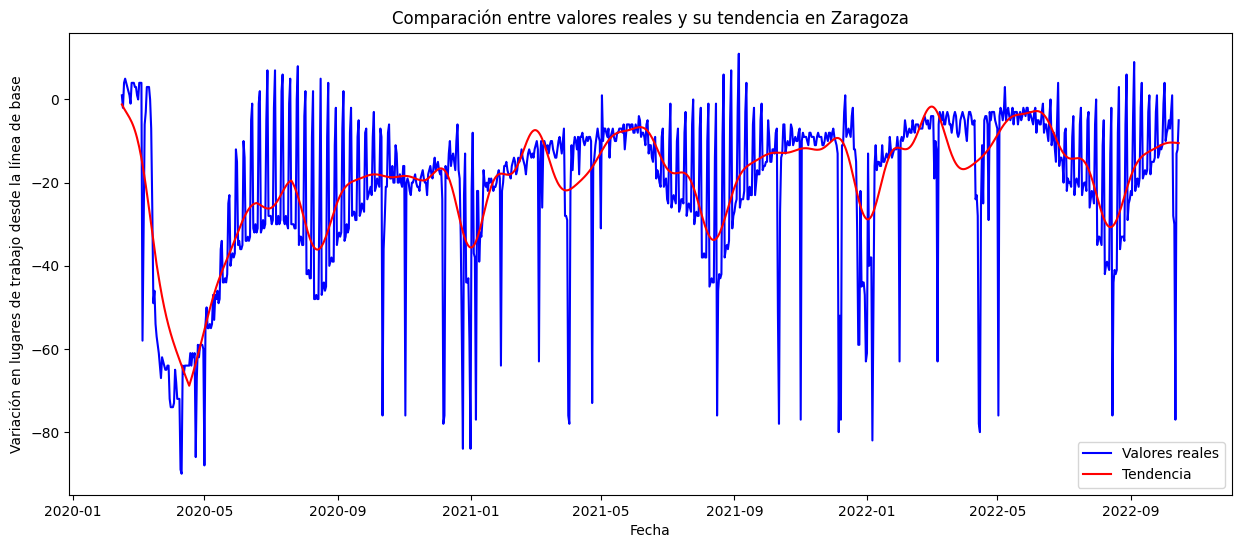

In [87]:
# Filtra los datos solo para la ciudad de 'Zaragoza'
zaragoza_data = data[data['iso_3166_2_code'] == 'ES-Z']

# Configura el tamaño del gráfico
plt.figure(figsize=(15, 6))

# Grafica la serie temporal 'workplaces_percent_change_from_baseline' para Zaragoza
plt.plot(zaragoza_data['date'], zaragoza_data['workplaces_raw'], label='Valores reales', color='blue')

# Grafica la serie temporal 'trend' para Zaragoza
plt.plot(zaragoza_data['date'], zaragoza_data['workplaces'], label='Tendencia', color='red')

# # Agregar indicador cuando la dummy es igual a 1
# dummy_indicator = zaragoza_data[zaragoza_data['d2'] == 1]
# plt.axvline(dummy_indicator['date'].values[0], color='green', linestyle='--', label='Dummy 1-0 = 1')

# dummy_indicator = zaragoza_data[zaragoza_data['d1'] == 1]
# plt.axvline(dummy_indicator['date'].values[0], color='red', linestyle='--', label='Dummy 2-1 = 1')

# Configura etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Variación en lugares de trabajo desde la línea de base')
plt.title('Comparación entre valores reales y su tendencia en Zaragoza')
plt.legend()

# Muestra el gráfico
plt.show()

In [88]:
data.drop('date', axis=1, inplace=True)
data = data.rename(columns={ 'ds': 'date'})

In [89]:
data

,country,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_raw,residential_percent_change_from_baseline,sub_region_1,iso_3166_2_code,...,workplaces,Valor_Stringency_Index,Valor_GovernmentResponseIndex,Valor_EconomicSupportIndex,Valor_Containment_Health_index,workplace_closing,daily_cases,d2,d1,Periodo
0,Germany,2020-02-15,6.0,1.0,52.0,10.0,3.0,-1.0,Baden-Württemberg,DE-BW,...,-6.951264,0.00,0.00,0.0,0.00,0.0,16.0,0,0,1
1,Germany,2020-02-16,23.0,43.0,64.0,20.0,1.0,-2.0,Baden-Württemberg,DE-BW,...,-7.310751,0.00,0.00,0.0,0.00,0.0,16.0,0,0,2
2,Germany,2020-02-17,0.0,-1.0,-11.0,0.0,-1.0,1.0,Baden-Württemberg,DE-BW,...,-7.566160,0.00,0.00,0.0,0.00,0.0,16.0,0,0,3
3,Germany,2020-02-18,4.0,3.0,16.0,1.0,0.0,1.0,Baden-Württemberg,DE-BW,...,-7.729673,0.00,0.00,0.0,0.00,0.0,16.0,0,0,4
4,Germany,2020-02-19,2.0,0.0,3.0,-2.0,-1.0,0.0,Baden-Württemberg,DE-BW,...,-7.815536,0.00,0.00,0.0,0.00,0.0,16.0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370555,Sweden,2022-10-11,-5.0,7.0,92.0,-16.0,-12.0,2.0,Västra Götaland County,SE-O,...,-12.062356,11.11,14.58,0.0,16.67,0.0,0.0,1,1,970
370556,Sweden,2022-10-12,-7.0,4.0,59.0,-22.0,-12.0,3.0,Västra Götaland County,SE-O,...,-12.272986,11.11,14.58,0.0,16.67,0.0,0.0,1,1,971
370557,Sweden,2022-10-13,-6.0,7.0,55.0,-19.0,-11.0,3.0,Västra Götaland County,SE-O,...,-12.466228,11.11,14.58,0.0,16.67,0.0,0.0,1,1,972
370558,Sweden,2022-10-14,-4.0,6.0,69.0,-18.0,-14.0,3.0,Västra Götaland County,SE-O,...,-12.639521,11.11,14.58,0.0,16.67,0.0,0.0,1,1,973


In [90]:
duplicates = data[data.duplicated()]

# # Si deseas contar el número de duplicados
num_duplicates = duplicates.shape[0]

# # Si deseas imprimir las filas duplicadas
print(duplicates)

data = data.drop_duplicates()

        country       date  \
80400   Germany 2021-01-01   
80402   Germany 2021-01-02   
80404   Germany 2021-01-03   
80406   Germany 2021-01-04   
80408   Germany 2021-01-05   
...         ...        ...   
171640   France 2021-12-27   
171642   France 2021-12-28   
171644   France 2021-12-29   
171646   France 2021-12-30   
171648   France 2021-12-31   

        retail_and_recreation_percent_change_from_baseline  \
80400                                               -88.0    
80402                                               -73.0    
80404                                               -67.0    
80406                                               -56.0    
80408                                               -57.0    
...                                                   ...    
171640                                                8.0    
171642                                                5.0    
171644                                               -3.0    
171646             

In [91]:
missing_count = data.isna().sum()
missing_count

country                                               0
date                                                  0
retail_and_recreation_percent_change_from_baseline    0
grocery_and_pharmacy_percent_change_from_baseline     0
parks_percent_change_from_baseline                    0
transit_stations_percent_change_from_baseline         0
workplaces_raw                                        0
residential_percent_change_from_baseline              0
sub_region_1                                          0
iso_3166_2_code                                       0
trend                                                 0
workplaces                                            0
Valor_Stringency_Index                                0
Valor_GovernmentResponseIndex                         0
Valor_EconomicSupportIndex                            0
Valor_Containment_Health_index                        0
workplace_closing                                     0
daily_cases                                     

In [92]:
# Utiliza groupby y count para contar las observaciones por individuo
observaciones_por_individuo = data.groupby('iso_3166_2_code').size()

# Muestra el resultado
print(observaciones_por_individuo)

iso_3166_2_code
DE-BB    974
DE-BE    974
DE-BW    974
DE-BY    974
DE-HB    974
        ... 
SE-U     968
SE-W     968
SE-X     968
SE-Y     968
SE-Z     968
Length: 334, dtype: int64


In [93]:
ruta_archivo_csv = r'C:\Users\34645\Desktop\Doctorado_II\Códigos_Python\IEDIS\Data\eu_data.csv'
data.to_csv(ruta_archivo_csv, index=False)  # index=False para no incluir el índice en el archivo CSV

In [ ]:
# Define la ruta del archivo CSV
ruta_archivo = r'C:\Users\34645\Desktop\Doctorado_II\Códigos_Python\IEDIS\Data\eu_data_filtered.csv'

# Cargar el archivo CSV en un DataFrame
data = pd.read_csv(ruta_archivo)

In [ ]:
# Filtrar las filas con fechas anteriores o iguales al 14 de noviembre de 2021
fecha_limite = pd.to_datetime('2021-11-14')
data_filtered = data[data['Week'] <= 90]

KeyError: 'Week'

In [ ]:
data

,iso_3166_2_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_raw,residential_percent_change_from_baseline,trend,workplaces,Valor_Stringency_Index,Valor_GovernmentResponseIndex,Valor_EconomicSupportIndex,Valor_Containment_Health_index,workplace_closing,daily_cases,d2,d1,Periodo
0,DE-BB,2020-02-16,6.500000,2.500000,17.000000,4.500000,0.500000,0.000000,4.674511,-2.591338,0.00,0.000000,0.0,0.00,0.0,16.000000,0,0,1
1,DE-BB,2020-02-23,0.142857,0.000000,1.142857,-1.285714,-0.285714,0.857143,1.519186,-1.302753,0.00,0.000000,0.0,0.00,0.0,16.000000,0,0,2
2,DE-BB,2020-03-01,3.285714,7.571429,12.428571,0.142857,0.285714,0.714286,-3.389097,-1.281404,0.00,0.000000,0.0,0.00,0.0,51.857143,0,0,3
3,DE-BB,2020-03-08,5.428571,7.285714,16.000000,-1.142857,0.857143,0.857143,-8.297381,-5.640300,0.00,0.000000,0.0,0.00,0.0,515.428571,0,0,4
4,DE-BB,2020-03-15,-2.000000,8.000000,26.428571,-7.142857,-1.000000,2.000000,-13.205664,-12.539735,0.00,0.000000,0.0,0.00,0.0,2953.428571,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46746,SE-Z,2022-09-18,-13.571429,0.285714,0.000000,-38.714286,-12.857143,1.571429,-19.039363,-15.274852,11.11,16.670000,0.0,19.05,0.0,0.000000,1,1,136
46747,SE-Z,2022-09-25,-9.571429,3.000000,0.000000,-37.571429,-11.428571,0.857143,-19.144914,-12.287451,11.11,14.878571,0.0,17.01,0.0,0.000000,1,1,137
46748,SE-Z,2022-10-02,-8.571429,-0.142857,0.000000,-40.142857,-10.142857,0.714286,-19.250465,-10.791190,11.11,14.580000,0.0,16.67,0.0,0.000000,1,1,138
46749,SE-Z,2022-10-09,-15.571429,-3.714286,0.000000,-42.714286,-10.285714,1.571429,-19.356016,-12.093726,11.11,14.580000,0.0,16.67,0.0,0.000000,1,1,139


In [95]:
# Seleccionar columnas numéricas
columnas_numericas = data.select_dtypes(include=['float64', 'int64']).columns

data['date'] = pd.to_datetime(data['date'])

# Configura 'date' como el índice del DataFrame
data.set_index('date', inplace=True)

# Selecciona las columnas numéricas
columnas_numericas = data.select_dtypes(include=['float64', 'int64']).columns

# Calcular el promedio semanal para las columnas numéricas por municipio
data_filtered_w = data.groupby(['iso_3166_2_code', pd.Grouper(freq='W')])[columnas_numericas].mean().reset_index()

# Mostrar los primeros registros del DataFrame con promedios semanales por municipio
print(data_filtered_w)

C:\Users\34645\AppData\Local\Temp\ipykernel_16368\3095065822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


      iso_3166_2_code       date  \
0               DE-BB 2020-02-16   
1               DE-BB 2020-02-23   
2               DE-BB 2020-03-01   
3               DE-BB 2020-03-08   
4               DE-BB 2020-03-15   
...               ...        ...   
46746            SE-Z 2022-09-18   
46747            SE-Z 2022-09-25   
46748            SE-Z 2022-10-02   
46749            SE-Z 2022-10-09   
46750            SE-Z 2022-10-16   

       retail_and_recreation_percent_change_from_baseline  \
0                                               6.500000    
1                                               0.142857    
2                                               3.285714    
3                                               5.428571    
4                                              -2.000000    
...                                                  ...    
46746                                         -13.571429    
46747                                          -9.571429    
46748             

In [96]:
# Ordénalos por 'Municipios' y 'Periodo'
data_filtered_w = data_filtered_w.sort_values(by=['iso_3166_2_code', 'date'])

# Reinicia el índice y crea una nueva columna 'Identificador'
data_filtered_w = data_filtered_w.reset_index(drop=True)
data_filtered_w['Week'] = data_filtered_w.groupby('iso_3166_2_code').cumcount() + 1

In [97]:
data_filtered_w['d2'] = 0  # Inicialmente, establece todos los valores en 0

# Condición 1: País es Sweden y fecha mayor o igual a '2021-07-15'
condicion_1 = (data_filtered_w['iso_3166_2_code'].str.startswith('SE')) & (data_filtered_w['Week'] >= 67) 
# Condición 2: País es España y fecha igual a '2021-08-23'
condicion_2 = (data_filtered_w['iso_3166_2_code'].str.startswith('ES')) & (data_filtered_w['Week'] >= 70) 

data
# Asigna 1 a la columna "dummy" si alguna de las condiciones se cumple
data_filtered_w.loc[condicion_1 | condicion_2, 'd2'] = 1

In [98]:
data_filtered_w['d1'] = 0  # Inicialmente, establece todos los valores en 0

# Condición 1: País es Sweden y fecha mayor o igual a '2021-07-15'
condicion_1 = (data_filtered_w['iso_3166_2_code'].str.startswith('SE')) & (data_filtered_w['Week'] >= 73) 
# Condición 2: País es España y fecha igual a '2021-08-23'
condicion_2 = (data_filtered_w['iso_3166_2_code'].str.startswith('ES')) & (data_filtered_w['Week'] >= 80) 

data
# Asigna 1 a la columna "dummy" si alguna de las condiciones se cumple
data_filtered_w.loc[condicion_1 | condicion_2, 'd1'] = 1

In [99]:
data_filtered_w

,iso_3166_2_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_raw,residential_percent_change_from_baseline,trend,workplaces,Valor_Stringency_Index,Valor_GovernmentResponseIndex,Valor_EconomicSupportIndex,Valor_Containment_Health_index,workplace_closing,daily_cases,d2,d1,Periodo,Week
0,DE-BB,2020-02-16,6.500000,2.500000,17.000000,4.500000,0.500000,0.000000,4.674511,-2.591338,0.00,0.000000,0.0,0.00,0.0,16.000000,0,0,1.5,1
1,DE-BB,2020-02-23,0.142857,0.000000,1.142857,-1.285714,-0.285714,0.857143,1.519186,-1.302753,0.00,0.000000,0.0,0.00,0.0,16.000000,0,0,6.0,2
2,DE-BB,2020-03-01,3.285714,7.571429,12.428571,0.142857,0.285714,0.714286,-3.389097,-1.281404,0.00,0.000000,0.0,0.00,0.0,51.857143,0,0,13.0,3
3,DE-BB,2020-03-08,5.428571,7.285714,16.000000,-1.142857,0.857143,0.857143,-8.297381,-5.640300,0.00,0.000000,0.0,0.00,0.0,515.428571,0,0,20.0,4
4,DE-BB,2020-03-15,-2.000000,8.000000,26.428571,-7.142857,-1.000000,2.000000,-13.205664,-12.539735,0.00,0.000000,0.0,0.00,0.0,2953.428571,0,0,27.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46746,SE-Z,2022-09-18,-13.571429,0.285714,0.000000,-38.714286,-12.857143,1.571429,-19.039363,-15.274852,11.11,16.670000,0.0,19.05,0.0,0.000000,1,1,944.0,136
46747,SE-Z,2022-09-25,-9.571429,3.000000,0.000000,-37.571429,-11.428571,0.857143,-19.144914,-12.287451,11.11,14.878571,0.0,17.01,0.0,0.000000,1,1,951.0,137
46748,SE-Z,2022-10-02,-8.571429,-0.142857,0.000000,-40.142857,-10.142857,0.714286,-19.250465,-10.791190,11.11,14.580000,0.0,16.67,0.0,0.000000,1,1,958.0,138
46749,SE-Z,2022-10-09,-15.571429,-3.714286,0.000000,-42.714286,-10.285714,1.571429,-19.356016,-12.093726,11.11,14.580000,0.0,16.67,0.0,0.000000,1,1,965.0,139


In [101]:
data_filtered_w.drop(columns=['Periodo'])

,iso_3166_2_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_raw,residential_percent_change_from_baseline,trend,workplaces,Valor_Stringency_Index,Valor_GovernmentResponseIndex,Valor_EconomicSupportIndex,Valor_Containment_Health_index,workplace_closing,daily_cases,d2,d1,Week
0,DE-BB,2020-02-16,6.500000,2.500000,17.000000,4.500000,0.500000,0.000000,4.674511,-2.591338,0.00,0.000000,0.0,0.00,0.0,16.000000,0,0,1
1,DE-BB,2020-02-23,0.142857,0.000000,1.142857,-1.285714,-0.285714,0.857143,1.519186,-1.302753,0.00,0.000000,0.0,0.00,0.0,16.000000,0,0,2
2,DE-BB,2020-03-01,3.285714,7.571429,12.428571,0.142857,0.285714,0.714286,-3.389097,-1.281404,0.00,0.000000,0.0,0.00,0.0,51.857143,0,0,3
3,DE-BB,2020-03-08,5.428571,7.285714,16.000000,-1.142857,0.857143,0.857143,-8.297381,-5.640300,0.00,0.000000,0.0,0.00,0.0,515.428571,0,0,4
4,DE-BB,2020-03-15,-2.000000,8.000000,26.428571,-7.142857,-1.000000,2.000000,-13.205664,-12.539735,0.00,0.000000,0.0,0.00,0.0,2953.428571,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46746,SE-Z,2022-09-18,-13.571429,0.285714,0.000000,-38.714286,-12.857143,1.571429,-19.039363,-15.274852,11.11,16.670000,0.0,19.05,0.0,0.000000,1,1,136
46747,SE-Z,2022-09-25,-9.571429,3.000000,0.000000,-37.571429,-11.428571,0.857143,-19.144914,-12.287451,11.11,14.878571,0.0,17.01,0.0,0.000000,1,1,137
46748,SE-Z,2022-10-02,-8.571429,-0.142857,0.000000,-40.142857,-10.142857,0.714286,-19.250465,-10.791190,11.11,14.580000,0.0,16.67,0.0,0.000000,1,1,138
46749,SE-Z,2022-10-09,-15.571429,-3.714286,0.000000,-42.714286,-10.285714,1.571429,-19.356016,-12.093726,11.11,14.580000,0.0,16.67,0.0,0.000000,1,1,139


In [102]:
ruta_archivo_csv = r'C:\Users\34645\Desktop\Doctorado_II\Códigos_Python\IEDIS\Data\eu_data_filtered_w.csv'
data_filtered_w.to_csv(ruta_archivo_csv, index=False)  # index=False para no incluir el índice en el archivo CSV